In [1]:
%pylab inline

import pandas as pd
import healpy as hp
import math

from scipy import interpolate, stats, special, arange, array, optimize
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord


Populating the interactive namespace from numpy and matplotlib


## Functions for likelihood

In [2]:
#HAWC Bkg Term
zenith = 50.
A = 0.5 * (special.erf(zenith/(np.sqrt(2)*23.55)) - special.erf(-zenith/(np.sqrt(2)*23.55)))
def probBkgHAWC(dec):
    #The 2 pi is from the uniform distribution in RA
    return A*exp(-(dec-18.98)**2/(2*23.55**2))/(np.sqrt(2*np.pi*np.deg2rad(23.55)**2) * 2*np.pi) 

# angular separation between two events
def spcang (ra1, ra2, dec1, dec2):
    ra1 = np.deg2rad(ra1)
    ra2 = np.deg2rad(ra2)
    dec1 = np.deg2rad(dec1)
    dec2 = np.deg2rad(dec2)
    return np.rad2deg(np.arccos(np.cos(dec1)*np.cos(dec2)*np.cos((ra1-ra2))+np.sin(dec1)*np.sin(dec2)))

# Define an initial space log-likelihood for each event (dec and ra are coordinates of the source position)
# Assumes a gaussian PDF
def loglh(dec1,ra1,dec,ra,sigma1,bkgterm):
    spc=np.deg2rad(spcang(ra1,ra,dec1,dec))
    #s = np.deg2rad(sigma1)**2+np.deg2rad(sigma)**2
    return -spc**2/(2*(np.deg2rad(sigma1))**2) - 0.5*np.log(2*np.pi*(np.deg2rad(sigma1))**2)-np.log(bkgterm)

# Find total log-likelihood considering multiplets: only spatial terms
def tloglh(dec,ra,events):
    val = 0
    for nut in events:
        dec1 = nut[0]
        ra1 = nut[1]
        sigma1 = nut[2]
        bkg=nut[4]
        # adding log-likelihood spatial terms
        val = val + loglh(dec1,ra1,dec,ra,sigma1,bkg)
    return val

def tloglh_time(dec,ra,events):
    val = 0
    for nut in events:
        dec1 = nut[0]
        ra1 = nut[1]
        sigma1 = nut[2]
        bkg=nut[4]
        # adding log-likelihood spatial terms
        val = val + loglh(dec1,ra1,dec,ra,sigma1,bkg)
    if len(events) > 2:
        for i in range(1,len(events)-1) :
            for j in range(i+1,len(events)) :
                # adding temporal term (T is a normlization factor that can be modified to match spatial terms)
                #val = val - abs(((events[i][3]-events[j][3])).seconds)/T
                val = val - abs(((events[i][3]-events[j][3])).seconds)/(events[0][3]*3600.) - np.log(events[0][3]*3600.)
    return val

def pNuCluster(events):
    val=1
    N=len(events)-1
    if N==1:
        return val
    else:
        lmb = 0.0066887 * events[0][3]*3600. #0.0066887 = 22334./ 3339043.sec
        for i in range(0,N-1) :
            val = val - np.exp(-lmb)*(lmb)**i/np.math.factorial(i)
    return val

#def pHAWC(events):
    

## Prepare data for more than one simulation

In [45]:
%%time
#Using several simulations
# Create a list of lists where each secondary list contains the photon event information and all its paired neutrinos
# photon: [RA, Dec, SigmaR], neutrino: [RA, Dec, SigmaR, timestamp]
minspc=3.5
#best_fit_val_time = []
best_fit_val = []

#Combine the HAWC month of data with 1200 scrambled months of IC data. -> Simulating 1200 months of data. 
for i in xrange(12):
    #HAWC sim
    #dfh = pd.read_csv("HAWC_simulations/2016-01-01_{}-times.txt".format(i+1),delimiter=" ")
    dfh = pd.read_csv("HAWC_scrambled/{}.csv".format(i))
    #dfh.head(2)
    dfh['HTime_c']=pd.to_datetime(dfh['HTime_c'])
    dfh = dfh.sort_values(by='HTime_c')
    dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
    dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])
    sigma_hawc = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=len(dfh), random_state=None)#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
    dfh['HsigmaR']=sigma_hawc
    #print dfh.head(0)
    #IC sim
    dfic = pd.read_csv("IC_scrambled2/{}.csv".format(i))
    #print dfic.head(0)
    dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
    dfic = dfic.sort_values(by='ICtime')
    #dfic['ICFPRD'] = np.power(10,-2.5)#np.power(10,signaless(len(dfic)))



    all_event_list=[]
    for h in dfh.itertuples():
        dfw=dfic[(pd.to_datetime(h.HTime_i)<=pd.to_datetime(dfic['ICtime']))&(pd.to_datetime(h.HTime_f)>=pd.to_datetime(dfic['ICtime']))]
        event_list=[]
        event_list.append([h.HDec,h.HRA,h.HsigmaR,h.Hduration,probBkgHAWC(h.HDec),1-stats.norm.cdf(h.Hsig)])
        for ic in dfw.itertuples():
            spc=spcang(h.HRA,ic.ICRA,h.HDec,ic.ICDec)
            if spc<minspc:
                event_list.append([ic.ICDec,ic.ICRA,ic.ICsigmaR,pd.to_datetime(ic.ICtime), np.deg2rad(np.deg2rad(ic.ICFPRD))*h.Hduration,1.])
        all_event_list.append(event_list)
    
    #Just paired events
    all_ev_nut = [x for x in all_event_list if len(x)>1]
    
    #print len(all_ev_nut)
    
    for ev in all_ev_nut:
        #if TempTerm:
        solution = optimize.minimize(lambda x: -tloglh_time(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')
        #else:
        #solution = optimize.minimize(lambda x: -tloglh(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')#'BFGS')
        pcluster = pNuCluster(ev)
        psigma = ev[0][5]
    
    
        stderr = 0.
        jacerr = 0.
        avgdist = 0.
        stddev = 0.
        j=0
        n=0

        if solution.success:
            res = list(solution.x)
            for part in ev:
                #print part[0],part[1],part[2],solution.x[0],solution.x[1]
                stderr += 1./(part[2]**2)
                tmpdist1 = spcang(solution.x[1],part[1],solution.x[0],part[0])/part[2]
                tmpdist2 = - 0.5*np.log(2*np.pi*np.deg2rad(part[2])**2) 
                stddev += spcang(solution.x[1],part[1],solution.x[0],part[0])**2
                avgdist +=tmpdist1#+ tmpdist2
                #print tmpdist1, tmpdist2
                j+=1
            #print avgdist,solution.fun
            stderr = np.sqrt(1/stderr)
            jacerr = np.sqrt(jacerr)
            avgdist /= j
            stddev /= j
            stddev = np.sqrt(stddev)
    
            res.append(stderr)
            #res.append(jacerr)
            res.append(-1*solution.fun)
            res.append(avgdist)
            res.append(stddev)
            res.append(len(ev)-1)
            res.append(pcluster)
            res.append(psigma)
            res.append(ev)
            best_fit_val.append(res)

CPU times: user 19min 10s, sys: 6.42 s, total: 19min 16s
Wall time: 19min 29s


In [46]:
likelihood = np.asarray([x[3] for x in best_fit_val])
likelihood_pair = np.asarray([x[3] for x in best_fit_val if len(x[-1]) <= 2])
likelihood_mult = np.asarray([x[3] for x in best_fit_val if len(x[-1]) > 2])
hawcPV = np.asarray([x[7] for x in best_fit_val])
pCluster = np.asarray([x[8] for x in best_fit_val])

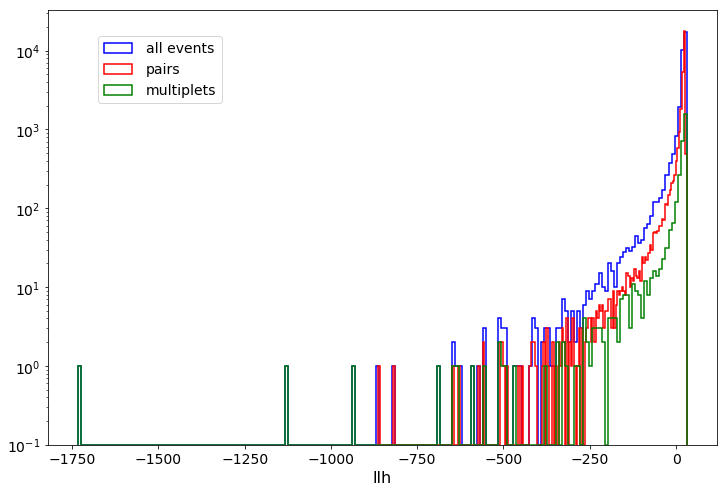

In [47]:
# Plot the histogram of llh values
rcParams['figure.figsize']=12,8
_=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         #range=[0,50],
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='r',
         lw=1.5,
         bins=200,
         #range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='g',
         lw=1.5,
         bins=200,
         #range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
l=legend(bbox_to_anchor=(0.26,0.94),loc=1,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'llh',fontsize=16)

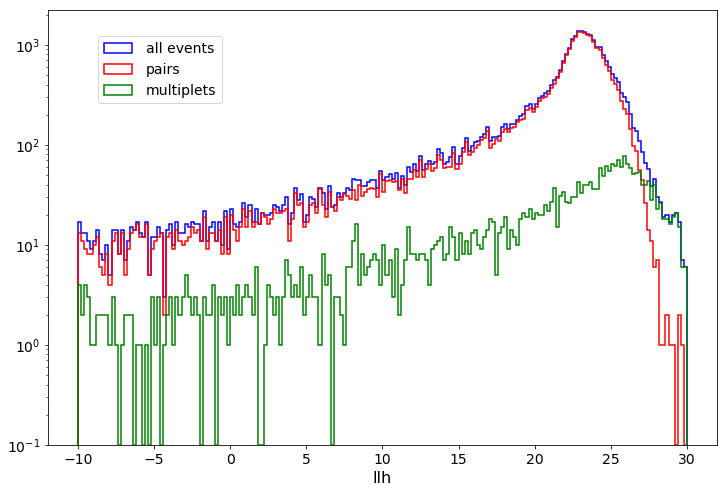

In [48]:
# Plot the histogram of llh values
rcParams['figure.figsize']=12,8
therange=[-10,30]
_=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         range=therange,
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='r',
         lw=1.5,
         bins=200,
         range=therange,
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='g',
         lw=1.5,
         bins=200,
         range=therange,
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
l=legend(bbox_to_anchor=(0.26,0.94),loc=1,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'llh',fontsize=16)
savefig("plots/llh_1year_v2.png")

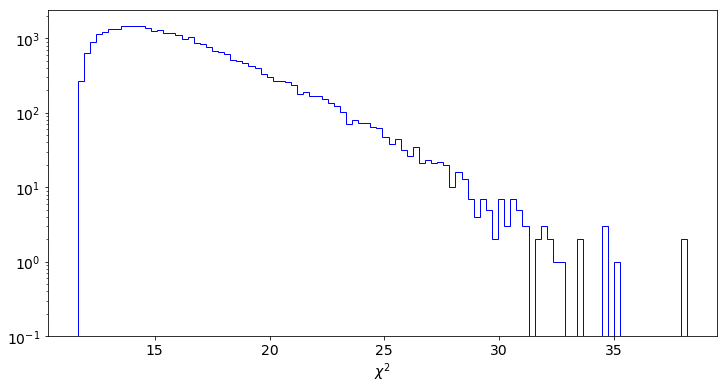

In [49]:
rcParams['figure.figsize']=12,6
rcParams['font.size']=14
cdfLLH =  np.load('CDF_LLH.npz')
CDF = []
for item in cdfLLH.iteritems():
    CDF.append(item[1])
n = CDF[0]
b = CDF[1]
bin_centers = b[:-1] + 0.5*(b[1:] - b[:-1])

f = interp1d(bin_centers, n)
chi2 = -2 * np.log(hawcPV*pCluster*(1-f(likelihood)))
n,b,o=hist(chi2,bins=100,histtype='step',log=True,color='b',label='All')
xlabel(r'$\chi^2$')
#grid(ls='--',which='both')
savefig("plots/chi2_1year_v2.png")

## Prepare Archival/Simulated Data

In [3]:
# Read HAWC data file
dfh = pd.read_csv("hawc_data_2.csv")
dfh['HTime_i']=pd.to_datetime(dfh['HTime_i'])
dfh['HTime_f']=pd.to_datetime(dfh['HTime_f'])
sigma_hawc = stats.lognorm.rvs(0.463632912751, loc=0.0302994104141, scale=0.0741518054165, size=len(dfh), random_state=None)#abs(random.normal(0.11,0.03)) #change HAWC sigmaR to be distributed around 0.1 for now
dfh['HsigmaR']=sigma_hawc
dfh['HTime_c']=pd.to_datetime(dfh['HTime_c'])
dfh = dfh.sort_values(by='HTime_c')
dfh.head(5)

,HDec,HRA,HsigmaR,HTime_i,HTime_c,HTime_f,Hduration,Hsig
1,-8.423330,256.377,0.081626,2016-01-01 14:03:17,2016-01-01 16:52:28,2016-01-01 19:41:39,5.63943,2.85261
27,-19.431800,258.047,0.092014,2016-01-01 14:49:10,2016-01-01 16:59:13,2016-01-01 19:09:16,4.33481,3.08562
14,-12.673900,258.487,0.092110,2016-01-01 14:24:19,2016-01-01 17:00:55,2016-01-01 19:37:31,5.22007,2.95240
7,-8.159460,258.882,0.096307,2016-01-01 14:12:34,2016-01-01 17:02:28,2016-01-01 19:52:22,5.66324,3.24719
3,-0.708832,261.123,0.073197,2016-01-01 14:04:34,2016-01-01 17:11:22,2016-01-01 20:18:10,6.22688,3.03762


In [4]:
# Read IceCube data file
dfic = pd.read_csv("ic-singlet-jan16.csv")
dfic['ICtime']=pd.to_datetime(dfic['ICtime'])
dfic = dfic.sort_values(by='ICtime')
dfic['ICFPRD'] = np.power(10,-2.5)#np.power(10,signaless(len(dfic)))
dfic.head(5)

,ICDec,ICRA,ICsigmaR,ICtime,ICmsec,ICFPRD
0,-34.7199,205.1050,0.196344,2016-01-01 00:04:57,98664,0.003162
1,54.3056,107.9430,0.534230,2016-01-01 00:05:40,122278,0.003162
2,57.3919,108.1390,1.176690,2016-01-01 00:05:48,730722,0.003162
3,-32.6259,332.9440,0.175290,2016-01-01 00:06:08,981306,0.003162
4,22.6634,20.1443,2.750110,2016-01-01 00:15:24,288569,0.003162


In [5]:
# Create a list of lists where each secondary list contains the photon event information and all its paired neutrinos
# photon: [RA, Dec, SigmaR], neutrino: [RA, Dec, SigmaR, timestamp]
minspc=3.5
FOV = np.deg2rad(50.)
hwcArea = 2.*np.pi*(1-np.cos(FOV))
all_event_list=[]
for h in dfh.itertuples():
    dfw=dfic[(pd.to_datetime(h.HTime_i)<=pd.to_datetime(dfic['ICtime']))&(pd.to_datetime(h.HTime_f)>=pd.to_datetime(dfic['ICtime']))]
    event_list=[]
    event_list.append([h.HDec,h.HRA,h.HsigmaR,h.Hduration,probBkgHAWC(h.HDec),1-stats.norm.cdf(h.Hsig)])
    for ic in dfw.itertuples():
        spc=spcang(h.HRA,ic.ICRA,h.HDec,ic.ICDec)
        if spc<minspc:
            event_list.append([ic.ICDec,ic.ICRA,ic.ICsigmaR,pd.to_datetime(ic.ICtime), 1/(2*np.pi), ic.ICFPRD])
    all_event_list.append(event_list)
    
#Just paired events
all_ev_nut = [x for x in all_event_list if len(x)>1]

In [6]:
len(all_ev_nut)

2493

In [7]:
# Use Scipy optimizer to find the Maximum likelihood and source position
# Case of llh with spatial terms: 
best_fit_val = []
#TempTerm=True
for ev in all_ev_nut:
    #if TempTerm:
    #solution = sc.optimize.minimize(lambda x: -tloglh_time(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')
    #else:
    solution = optimize.minimize(lambda x: -tloglh(x[0],x[1],ev),np.array([ev[0][0]+0.1,ev[0][1]+0.1]), method = 'SLSQP')#'BFGS')
    pcluster = pNuCluster(ev)
    psigma = ev[0][5]
    
    
    stderr = 0.
    jacerr = 0.
    avgdist = 0.
    stddev = 0.
    j=0
    n=0

    if solution.success:
        res = list(solution.x)
        for part in ev:
            #print part[0],part[1],part[2],solution.x[0],solution.x[1]
            stderr += 1./(part[2]**2)
            tmpdist1 = spcang(solution.x[1],part[1],solution.x[0],part[0])/part[2]
            tmpdist2 = - 0.5*np.log(2*np.pi*np.deg2rad(part[2])**2) 
            stddev += spcang(solution.x[1],part[1],solution.x[0],part[0])**2
            avgdist +=tmpdist1#+ tmpdist2
            #print tmpdist1, tmpdist2
            j+=1
        #print avgdist,solution.fun
        stderr = np.sqrt(1/stderr)
        jacerr = np.sqrt(jacerr)
        avgdist /= j
        stddev /= j
        stddev = np.sqrt(stddev)
    
        res.append(stderr)
        #res.append(jacerr)
        res.append(-1*solution.fun)
        res.append(avgdist)
        res.append(stddev)
        res.append(len(ev)-1)
        res.append(pcluster)
        res.append(psigma)
        res.append(ev)
        best_fit_val.append(res)

In [12]:
likelihood = np.asarray([x[3] for x in best_fit_val])
likelihood_pair = np.asarray([x[3] for x in best_fit_val if len(x[-1]) <= 2])
likelihood_mult = np.asarray([x[3] for x in best_fit_val if len(x[-1]) > 2])

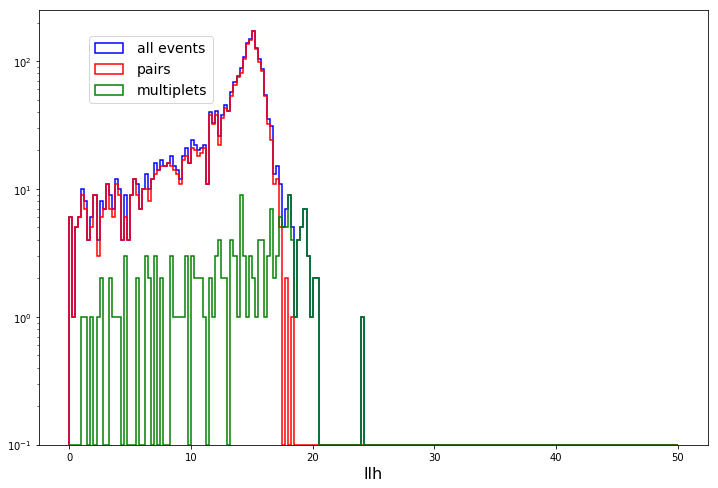

In [10]:
# Plot the histogram of llh values
rcParams['figure.figsize']=12,8
_=plt.hist(likelihood,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='b',
         lw=1.5,
         bins=200,
         range=[0,50],
         histtype='step',
         label=r'all events')
_=plt.hist(likelihood_pair,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='r',
         lw=1.5,
         bins=200,
         range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'pairs')
_=plt.hist(likelihood_mult,
         #cumulative=True,normed=1,histtype='step',
         log=True,
         color='g',
         lw=1.5,
         bins=200,
         range=[0,50],
         #alpha=0.5,
         histtype='step',
         label=r'multiplets')
l=legend(bbox_to_anchor=(0.26,0.94),loc=1,borderaxespad=0,numpoints=1,fancybox=True,
         handletextpad=1,handlelength=2,prop={'size':14})
xlabel(r'llh',fontsize=16)
#xscale('log')